In [1]:
import re, os
from src.graph_parameters import GraphParameters
from src.graph_stats import GraphStats
from src.dag_generational_comparison import DAG_GenerationalComparison
from src.dag import DAG
from src.node import Node
from src.edge import Edge
from src.utils import load_dag

In [2]:
pkl_re = re.compile('.*P[0-9]*\\\\dag.pkl')
data_files = [os.path.join(path, name) for path, _, files in os.walk('.\\data') for name in files]
graph_files = list(filter(pkl_re.match, data_files)) 
print(f"Currently avalible graph files: {graph_files}")

dag_names = []
dags = []

for g in graph_files:
    dag_id = g.split('data\\')[1].split('\\')[0]
    dag_stats = f'results/{dag_id}_dag_with_stats.pkl'
    rec_file = g.split('dag.pkl')[0] + 'reconstruction.npy'
    dag_with_stats = load_dag(dag_stats)
    dags.append(dag_with_stats)
    dag_names.append(dag_id)

Currently avalible graph files: ['.\\data\\P01\\dag.pkl', '.\\data\\P07\\dag.pkl', '.\\data\\P09\\dag.pkl', '.\\data\\P12\\dag.pkl', '.\\data\\P18\\dag.pkl']


In [3]:
from src.graph_stats import GraphStats
gs = GraphStats(dags[0], "P01")
gs.mean_length()

<Figure size 432x288 with 0 Axes>

d:\AnalizaParametrowMorfometrycznychNerki\src\dag_generational_comparison.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.setp(axis, xticklabels=self.dag_names)


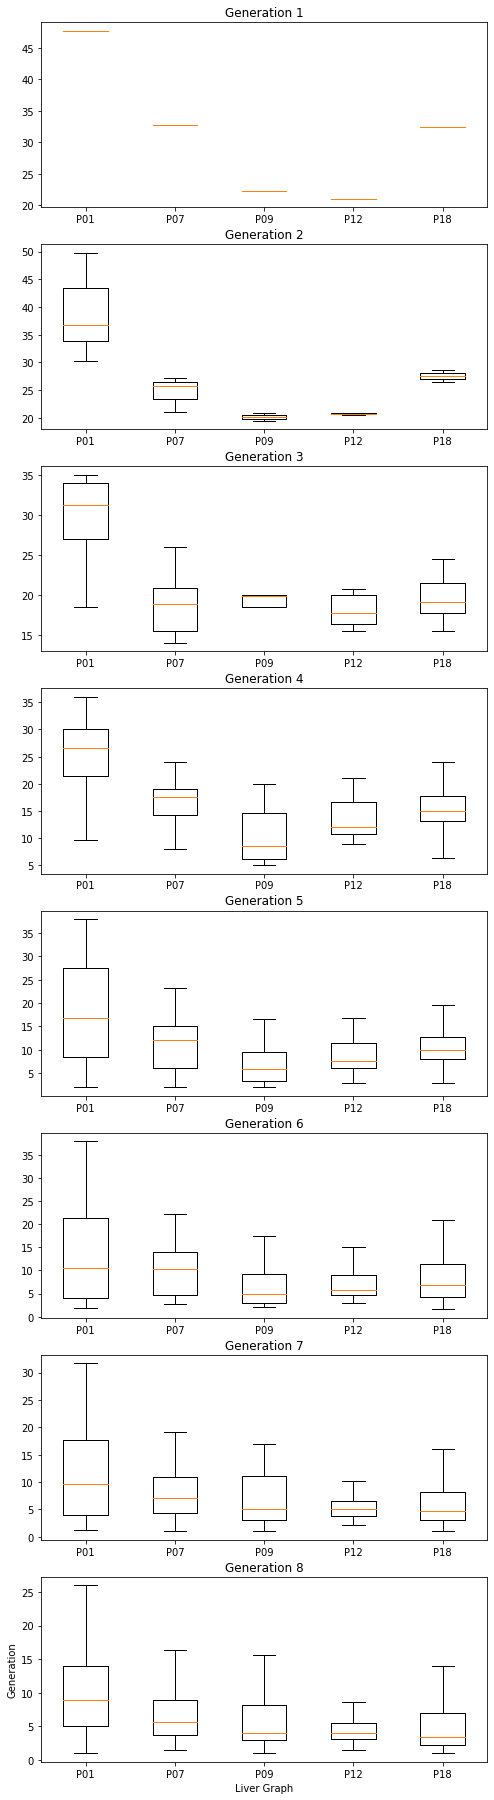

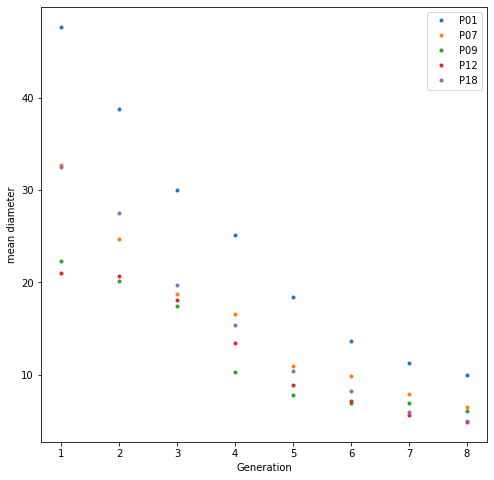

In [4]:
dag_gen_comparison = DAG_GenerationalComparison(dags, dag_names, 8)
# dag_gen_comparison.compare_lengths(False)
dag_gen_comparison.compare_diameters(False)